# Reconocimiento de Imágenes en CIFAR10

Para experimentar con el reconocimiento de imágenes y la clasificación se estudia el dataset *CIFAR10*, el cual contiene 60.000 imagenes de 32 $\times$ 32 (pixeles), donde cada imagen pertenece a una de las diez clases, clasificación excluyente (gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco). Los datos vienen estructurado en un formato RGB, donde cada imagen (fila del dataset) corresponde a 3072 características, dividido en los 3 canales de RGB (1024 cada uno) correspondiente a cada imagen.  
Los datos vienen separados en datos de entrenamiento y de pruebas, para un estudio eficiente con las distintas arquitecturas que ofrecen las *redes neuronales*, además de analizar distintas representaciones de imágenes.

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]
min value 0
max value 255


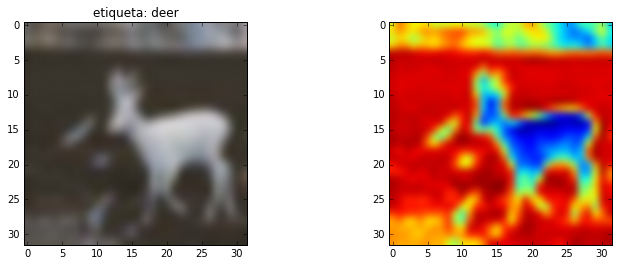

In [1]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

dict1 = unpickle("data/data_batch_1")
X = dict1["data"]
print X
Y = dict1['labels']
print "min value" ,min(X[0])
print "max value" ,max(X[0])

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

import numpy as np

def ver_imagen(X,Y,n):
    aux = X[n].reshape(3,1024).copy()
    imagen = np.zeros((32,32,3))
    canal_r = aux[0].reshape(32,32)
    canal_g = aux[1].reshape(32,32)
    canal_b = aux[2].reshape(32,32)
    for i in range(len(aux)):
        imagen[:,:,i] = aux[i].reshape(32,32)
    
    import matplotlib.pyplot as plt
    f,ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].set_title("etiqueta: "+label_names[Y[n]])
    ax[0].imshow(imagen, interpolation="bicubic")

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    plt.show()
    
ver_imagen(X,Y,20)

Como se ve en lo anterior cada pixel de cada imágen tiene un rango en el que varía, entre 0 y 255, siendo 0 la intensidad mínima del pixel en ese canal y 255 la intensidad máxima, además de mostrar una imagen para saber como es su apreciación visual de estas matrices que para los humanos no tienen un significado alguno, a la izquierda la imagen normal y a la derecha la imagen con los 3 canales RGB sobrepuestos

## A) Cargar Dataset

In [26]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os

def load_CIFAR_one(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f)
        X = datadict["data"]
        Y = datadict["labels"]
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, "data_batch_%d" % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, "test_batch"))
    
    #adding Xval
    index = np.arange(np.shape(Xtr)[0]) #filas 
    np.random.shuffle(index) #permutan las filas
    X = Xtr[index, :] #matriz permutada
    Y = Ytr[index]
    #l =  np.random.randint(1000,5000) #entrego 4259
    l = 4259
    Xval,Xtr = np.split(X,[l])
    Yval,Ytr = np.split(Y,[l])
    
    return Xtr, Ytr, Xte, Yte,Xval,Yval

X_train,Y_train, X_test,Y_test, X_val,Y_val = load_CIFAR10('data/')

print 'Training set shape: ',X_train.shape
print 'Validation set shape: ',X_val.shape
print 'Test set shape: ',X_test.shape 

Training set shape:  (45741, 3072)
Validation set shape:  (4259, 3072)
Test set shape:  (10000, 3072)


En la celda anterior se carga el dataset de CIFAR10, el cual está dividido en *batchs*. Se crean las matrices $X_{train}$, $Y_{train}$, $X_{test}$, $Y_{test}$ y $X_{val}$, $Y_{val}$. El conjunto de validación es creado a partir del *training set* y este no supera los 5000 datos. Las filas de estas matrices representan a cada imagen del dataset, siendo los valores de la fila valores enteros de 0 a 255, que representan los valores de los colores que vienen por los canales *R*,*G* y *B*.  
Se puede observar que la matriz $X_{train}$ posee 45741 filas, es decir, 45741 imagenes de entrenamiento. Por otro lado $X_{val}$ posee 4259 imágenes de validación y $X_{test}$ 10000 imágenes de prueba. Las 10 etiquetas están codificadas en números enteros del 0 al 9.  

Es importante destacar que las matrices $X_{train}$ y $X_{val}$ son creadas de manera aleatoria seleccionando las filas permutadas.

## B) Escalamiento

Datos centrados
[[  93.44089548   83.01112787   62.07148947 ...,  -51.67014276
   -48.79753394  -53.29885661]
 [ -65.55910452  -68.98887213  -72.92851053 ...,  104.32985724
   105.20246606  105.70114339]
 [   9.44089548   12.01112787   10.07148947 ...,  -17.67014276
   -19.79753394  -24.29885661]
 ..., 
 [ -75.55910452  -93.98887213  -62.92851053 ...,   37.32985724
    36.20246606   36.70114339]
 [  37.44089548   40.01112787   43.07148947 ...,  -58.67014276
   -57.79753394  -57.29885661]
 [  45.44089548   38.01112787   49.07148947 ...,  -51.67014276
   -51.79753394  -50.29885661]]


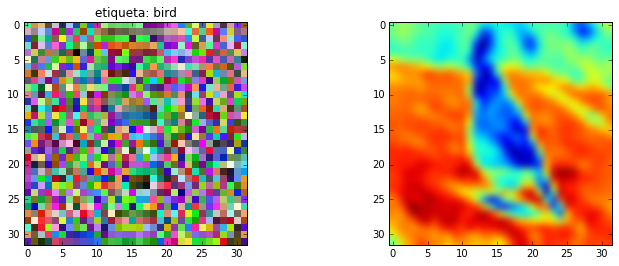

Datos centrados y escalados normalmente
[[ 1.27195515  1.14486084  0.85859986 ..., -0.79733212 -0.74921203
  -0.80740412]
 [-0.89241697 -0.95147073 -1.0087789  ...,  1.60993452  1.61522411
   1.60122644]
 [ 0.12851328  0.16565333  0.13931323 ..., -0.27267144 -0.30396107
  -0.36809414]
 ..., 
 [-1.028541   -1.29626211 -0.87045455 ...,  0.57604436  0.55583389
   0.55597167]
 [ 0.50966057  0.55181968  0.59578359 ..., -0.9053505  -0.88739336
  -0.8679986 ]
 [ 0.61855979  0.52423637  0.6787782  ..., -0.79733212 -0.79527248
  -0.76195826]]


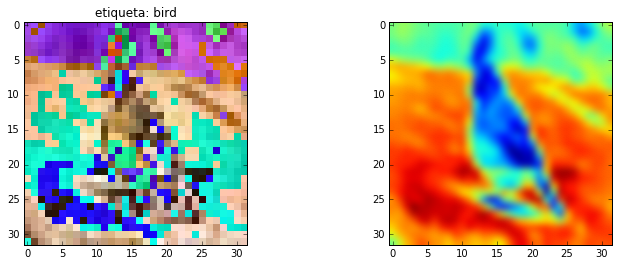

In [29]:
# Escalar y centrar datos
from sklearn.preprocessing import StandardScaler

def scaler_t(X,Xv,Xt,scaler_type):
    if scaler_type == "centrar":
        scaler= StandardScaler(with_std=False).fit(X)
        return scaler.transform(X), scaler.transform(Xv), scaler.transform(Xt)
    elif scaler_type == "centrar_escalar":
        scaler= StandardScaler(with_std=True).fit(X)
        return scaler.transform(X), scaler.transform(Xv), scaler.transform(Xt)
    else: #otro
        return X*0.5
    
print "Datos centrados"
X,Xv,Xt = scaler_t(X_train,X_val,X_test,"centrar")
print X
ver_imagen(X,Y_train,20)

print "Datos centrados y escalados normalmente"
X,Xv,Xt = scaler_t(X_train,X_val,X_test,"centrar_escalar")
print X
ver_imagen(X,Y_train,20)

En esta celda se escala la representación matricial de píxeles de las imágenes, para poder trabajarlas de forma apropiada. Mostrándo las imágenes a la izquierda y a la derecha, ambas escaladas solo que la imagen de la derecha tiene los canales RGB sobrepuestos.  
Se puede ver que en este tipo de representación escalada y centrada se pierde completamente la visualización de la imagen, teniendo muchos colores encima dando la sensación de que no es nada más que una mancha, por lo que para nosotros, los humanos, esto no tiene mucho significado e interpretación

## C) ANN - Análisis

In [4]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop

Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"centrar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos centrados"

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.2), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.01))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) = %f"% model.evaluate(Xv, Yv)

print "------------------------------------------------"

Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"centrar_escalar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos centrados y escalados"
#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.2), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) = %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.01))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) = %f"% model.evaluate(Xv, Yv)

Using Theano backend.


Para representacion datos centrados
4259/4259 [==============================] - 0s     

VALIDATION ERROR (activation relu-softmax) = 2.898918
4224/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) = 2.755139
4224/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) = 0.264310
4259/4259 [==============================] - 0s     

VALIDATION ERROR (activation relu-softmax) = 0.271349
4224/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation sigmoid-softmax) = 0.250259
4256/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation sigmoid-softmax) = 0.271350
4224/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation sigmoid-softmax) = 0.270396
------------------------------------------------
Para representacion datos centrados y escalados
4256/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) = 0.211967


En la celda anterior se ajusta una red neuronal con distintas arquitecturas para los datos escalados, midiendo el error sobre el *validation set* logrando decidir que la mejor configuración es la de usar la representación RGB de los datos normalizados de manera estándar (centrar y escalar).  
Se varió la función de activación en la capa escondida, el **learning rate**, el tamaño del **batch** y el valor de regularización **Dropout**.  
La arquitectura que tuvo un mejor desempeño fue con una capa escondida con 100 neuronas, con función de activación **relu**, Dropout de 0,1, optimizador SGD con **learning rate** de 0,1, tamaño del **batch** 200 y 50 **epochs**. A continuación se presenta el efecto de esta configuración sobre el *test set*.  

In [13]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop

Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"centrar_escalar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nTEST ERROR (activation relu-softmax) = %f"% model.evaluate(Xt, Yt)

 9824/10000 [============================>.] - ETA: 0s
TEST ERROR (activation relu-softmax) = 0.212475


Para la configuración descrita anteriormente se logra un error del **21,25%** sobre el conjunto de prueba, bastante más bajo y mejor de lo que se esperaba (50%), logrando un desempeño muy bueno para la red neuronal con la representación en píxeles RGB de los datos escalados normalmente.

## D) Cambio de Representación

In [5]:
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features
X_train, Y_train, X_test, Y_test,X_val,Y_val = load_CIFAR10("data/")
print "dimensiones de conjunto de entrenamiento ", X_train.shape

features = extract_features(X_train,[hog_features],verbose=0) #extrae hog features
print 'Dimensiones de representacion segun histograma de gradientes: ',features.shape
features = extract_features(X_train,[color_histogram_hsv]) #extrae histogramas de color
print 'Dimensiones de representacion segun histogramas de color: ',features.shape
features = extract_features(X_train,[hog_features, color_histogram_hsv]) #extrae todo
print 'Dimensiones de representacion mixta: ' ,features.shape

dimensiones de conjunto de entrenamiento  (45741, 3072)
(45741, 32, 32, 3)
Dimensiones de representacion segun histograma de gradientes:  (45741, 144)
(45741, 32, 32, 3)
Dimensiones de representacion segun histogramas de color:  (45741, 10)
(45741, 32, 32, 3)
Dimensiones de representacion mixta:  (45741, 154)


Para la celda anterior se mejoran los atributos cambiando la representación orientado al cambio de dimensionalidad. Este cambio dimensional se produce por la extracción de características de cada representación, en este caso esa extracción se interpreta como la frecuencia de ciertos colores en el caso de los histogramas de color y las direcciones del gradiente en el caso de los histogramas de gradientes.  

Se puede observar que el número de columnas para la representación segun *histograma de gradientes* es de 144, lo que quiere decir que esta representación extrae 144 características que simbolizan las direcciones del gradiente, valores que tienen un rango entre 0 y 1.  
Para el caso de la representación segun *histogramas de color* el numero de columnas es de 10, lo que quiere decir que esta representación extrae 10 características que simbolizan las frecuencias de los colores, donde los valores tienen un rango variable.  
Y por último, la representacion mixta que posee 154 columnas, que simbolizan las direcciones del gradiente y las frecuencias de colores, siendo esta representación la concatenación de las dos anteriores.

En la celda anterior y en la siguiente se cambia la representación de los datos en base a características de mas alto nivel como lo son los histogramas de gradientes, donde se ven las direcciones de la forma de la figura en la imagen, los histogramas de color, basado en los distintos tonos de colores presentes en la imagen y finalmente, una representación mixta de ambas representaciones. Se puede ver la clara disminución de columnas en base a las características de la representación original, ya que disminuye de 3072 a menos de 200.

In [6]:
def representacion(x,xv,xt,tipo):
    if tipo=="hog":
        features_train = extract_features(x,[hog_features]) #extrae hog features
        features_val = extract_features(xv,[hog_features]) #extrae hog features
        features_test = extract_features(xt,[hog_features]) #extrae hog features
    elif tipo=="histogram":
        features_train = extract_features(x,[color_histogram_hsv]) #extrae histogramas de color
        features_val = extract_features(xv,[color_histogram_hsv]) #extrae histogramas de color
        features_test = extract_features(xt,[color_histogram_hsv]) #extraehistogramas de color
    else:
        features_train = extract_features(x,[hog_features, color_histogram_hsv]) #extrae todo
        features_val = extract_features(xv,[hog_features, color_histogram_hsv]) #extrae todo
        features_test = extract_features(xt,[hog_features, color_histogram_hsv]) #extrae todo

    return features_train,features_val,features_test

In [10]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop

Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"hog")

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) 0.1 dropout in HOG= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) 0.2 dropout in HOG= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) 0.1 lr in HOG= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) 0.01 lr in HOG= %f"% model.evaluate(Xv, Yv)

print "------------------------------------------------"

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"histogram")

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) 0.1 dropout in COLOR HISTOGRAM= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) 0.2 dropout in COLOR HISTOGRAM= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) 0.1 lr in COLOR HISTOGRAM= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) 0.01 lr in COLOR HISTOGRAM= %f"% model.evaluate(Xv, Yv)

print "------------------------------------------------"

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinados")

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) 0.1 dropout in COMBINED= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation relu-softmax) 0.2 dropout in COMBINED= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) 0.1 lr in COMBINED= %f"% model.evaluate(Xv, Yv)

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nVALIDATION ERROR (activation sigmoid-softmax) 0.01 lr in COMBINED= %f"% model.evaluate(Xv, Yv)

(45741, 32, 32, 3)
(4259, 32, 32, 3)
(10000, 32, 32, 3)
4096/4259 [===========================>..] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) 0.1 dropout in HOG= 0.236716
4192/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) 0.2 dropout in HOG= 0.238108
4096/4259 [===========================>..] - ETA: 0s
VALIDATION ERROR (activation sigmoid-softmax) 0.1 lr in HOG= 0.221308
3936/4259 [==========================>...] - ETA: 0s
VALIDATION ERROR (activation sigmoid-softmax) 0.01 lr in HOG= 0.280157
------------------------------------------------
(45741, 32, 32, 3)
(4259, 32, 32, 3)
(10000, 32, 32, 3)
4192/4259 [============================>.] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) 0.1 dropout in COLOR HISTOGRAM= 0.324574
3904/4259 [==========================>...] - ETA: 0s
VALIDATION ERROR (activation relu-softmax) 0.2 dropout in COLOR HISTOGRAM= 0.324554
4192/4259 [============================>.] - ETA: 0s
VALIDATION ERRO

En la celda anterior se ve el efecto de las representaciones de alto nivel implementadas.  
La representación de gradientes (HOG) obtiene menor error que la de histogramas de color, lo que puede ser causado ya que los histogramas de color al tener solo 10 características son muy pocas y no tan informativas en predecir la etiqueta de la imagen. Siendo la mejor representación según el score en el *validation set* la combinada, es decir, incluyendo las características de los histogramas de color (tono) y gradiente, se presenta su evaluación sobre el *test set* a continuación. 

In [12]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinados")
Ytr = to_categorical(Y_train)
Yt = to_categorical(Y_test)
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.1), loss='binary_crossentropy')
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=200, verbose=0, validation_data=(Xv,Yv))
print "\nTest ERROR (activation sigmoid-softmax) 0.1 lr in COMBINED = %f"% model.evaluate(Xt, Yt)

(45741, 32, 32, 3)
(4259, 32, 32, 3)
(10000, 32, 32, 3)
10000/10000 [==============================] - 0s     

Test ERROR (activation sigmoid-softmax) 0.1 lr in COMBINED = 0.222035


Se presenta un error del **22,20%** sobre el conjunto de pruebas para esta representación de alto nivel, valor 1% más alto que la representación original de bajo nivel, por lo que al extraer estas representaciones no mejora el desempeño de la *red neuronal*.  

**Observaciones Finales**  
* En esta parte observamos la importancia que hay en una correcta manipulación de los datos dependiendo del objetivo final. Observamos que, en general, si se escalan y centran los datos se obtienen mejores resultados a la hora de entrenar las redes comparado a solo centrar los datos.
    
* Probando distintas arquitecturas y entrenamientos llegamos a una tasa de error de 21,25% y 22,20%, menor que la mitad de lo propuesto (50%). Los cambios respectos al error más significativo fueron en el cambio de funciones de activación y en la modificación de learning de rate en el método de aprendizaje.
    
* Con el cambio de representación, se redujo la dimensionalidad de las imágenes a una de mas alto nivel. Por lo que se tienen dos puntos de vista donde en uno se pensaría que transmiten menos información que antes ya que la cantidad de características es mucho menor respecto a la original, por lo tanto, haría la tarea de reconocimiento mucho más compleja. El otro caso es que estas características al ser de mas alto nivel transmiten información que no transmiten por sí solas la representación original, por lo que se comportarían mejor que estas en la clasificación de imágenes haciendo la tarea de reconocimiento más sencilla.  
Experimentalmente ninguno de los casos se dio claramente, dado que se obtuvo un valor de error muy cercano al utilizar la representación con las 3072 características, esto implica en primer lugar que las representaciones caracterizan muy bien al conjunto de datos, por lo que esta cantidad pequeña de características logra describir bien las imágenes. Por otro lado no se logra una mejora respecto a la representación original de píxeles.

* Las representaciones de alto nivel no logran un desempeño mejor que la representación original de los datos. La red neuronal neuronal, dentro de su entrenamiento, intrínsecamente hace este trabajo de encontrar una representación amena de los datos para así realizar la tarea correctamente, este proceso de encontrar la representación más óptima para la tarea se denomina *feature learning*.

* Las ventajas del cambio de representación es que reduce la complejidad computacional, se podría entrenar la red siempre con las representaciones de alto nivel en vez que las representaciones de píxeles, y aún así obtener valores muy cercanos de error.